In [1]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Preprocessing

Numeric features are scaled using MinMaxScaler to a 0–1 range.

Target labels are converted to integer class labels using LabelEncoder.
Preprocessing is fit on the training data only to maintain proper evaluation integrity
.

In [2]:
# making the random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# loading the data
df = pd.read_csv(r"C:\Users\jiaro\DS4021-final-project\Data\train_set.csv")

X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
# identifying numeric and categorical columns (for later)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# label encoding the target variable (so we are doing multi-class classification and because cross-entropy loss needs integer class labels)
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
# making the preprocessor so the numeric features are scaled and the categorical features are one-hot encoded (also unknown categories are ignored)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)


NN architecture

Input layer

One hidden layer with ReLU activation

Dropout for regularization

Output layer corresponding to the number of classes

Training uses CrossEntropyLoss and the Adam optimizer.

In [ ]:
# setting up on NN with one hidden layer, dropout, and output layer for multi-class classification
class NNClassifier(nn.Module):
    def __init__(self, input_dim, hidden=64, dropout=0.2, num_classes=7):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [4]:
# training function - trains the model and evaluates on validation set

def train_model(X_train, y_train, X_val, y_val, params):
    hidden = params["hidden"]
    lr = params["lr"]
    epochs = params["epochs"]
    batch_size = params["batch_size"]
    dropout = params["dropout"]

    model = NNClassifier(
        input_dim=X_train.shape[1],
        hidden=hidden,
        dropout=dropout,
        num_classes=len(np.unique(y_train))
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
    val_ds = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_val).float()).argmax(dim=1).numpy()

    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="weighted")

    return model, acc, f1


Multiple values are tested for:

Hidden layer size

Learning rate

Dropout rate

Batch size

Number of epochs

The combination with the highest average F1-score is selected.

In [5]:
param_grid = {
    "hidden": [32, 64, 128],
    "dropout": [0.0, 0.2, 0.5],
    "lr": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "epochs": [20]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = []
best_f1 = -1
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    print("\nTesting params:", params)
    accs = []
    f1s = []

    for train_idx, val_idx in skf.split(X_train, y_train_enc):
        X_tr_df = X_train.iloc[train_idx]
        y_tr = y_train_enc[train_idx]
        X_val_df = X_train.iloc[val_idx]
        y_val = y_train_enc[val_idx]

        # Preprocess inside CV
        X_tr_np = preprocessor.fit_transform(X_tr_df)
        X_val_np = preprocessor.transform(X_val_df)

        # Train
        model, acc, f1 = train_model(X_tr_np, y_tr, X_val_np, y_val, params)

        accs.append(acc)
        f1s.append(f1)

    mean_acc = np.mean(accs)
    mean_f1 = np.mean(f1s)

    print(f" → Mean Acc={mean_acc:.3f}, Mean F1={mean_f1:.3f}")

    results.append({"params": params, "acc": mean_acc, "f1": mean_f1})

    # if this hyperparameter set is the best so far:
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_params = params
        best_model = model  # last trained model (fine for simple MLP)



Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 32, 'lr': 0.001}
 → Mean Acc=0.799, Mean F1=0.794

Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 32, 'lr': 0.0001}
 → Mean Acc=0.461, Mean F1=0.417

Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 64, 'lr': 0.001}
 → Mean Acc=0.827, Mean F1=0.824

Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 64, 'lr': 0.0001}
 → Mean Acc=0.511, Mean F1=0.459

Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.001}
 → Mean Acc=0.882, Mean F1=0.882

Testing params: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.0001}
 → Mean Acc=0.585, Mean F1=0.547

Testing params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'hidden': 32, 'lr': 0.001}
 → Mean Acc=0.781, Mean F1=0.774

Testing params: {'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'hidden': 32, 'lr': 0.0001}
 → Mean Acc=0.464, 

After selecting the best hyperparameters, the model is retrained on the entire training set (all folds combined) to maximize the amount of data available for learning. Performance is measured on the held-out test set using:

Accuracy

F1-score

Classification report

Confusion matrix

In [6]:
# use best params
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

# retrain!
best_model, _, _ = train_model(
    X_train_final, y_train_enc,
    X_test_final, y_test_enc,
    best_params
)

# final pred
best_model.eval()
with torch.no_grad():
    preds_test = best_model(torch.tensor(X_test_final).float()).argmax(dim=1).numpy()

test_acc = accuracy_score(y_test_enc, preds_test)
test_f1 = f1_score(y_test_enc, preds_test, average="weighted")

print("\nBEST PARAMS:", best_params)
print("TEST ACC:", test_acc)
print("TEST F1:", test_f1)



BEST PARAMS: {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'hidden': 128, 'lr': 0.001}
TEST ACC: 0.9142011834319527
TEST F1: 0.9148544301112799



TEST ACCURACY: 0.9142011834319527
TEST F1: 0.9148544301112799

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.91      0.93      0.92        43
      Normal_Weight       0.84      0.82      0.83        45
     Obesity_Type_I       0.96      0.89      0.92        55
    Obesity_Type_II       0.98      0.98      0.98        48
   Obesity_Type_III       1.00      0.98      0.99        52
 Overweight_Level_I       0.93      0.85      0.89        47
Overweight_Level_II       0.79      0.94      0.86        48

           accuracy                           0.91       338
          macro avg       0.92      0.91      0.91       338
       weighted avg       0.92      0.91      0.91       338



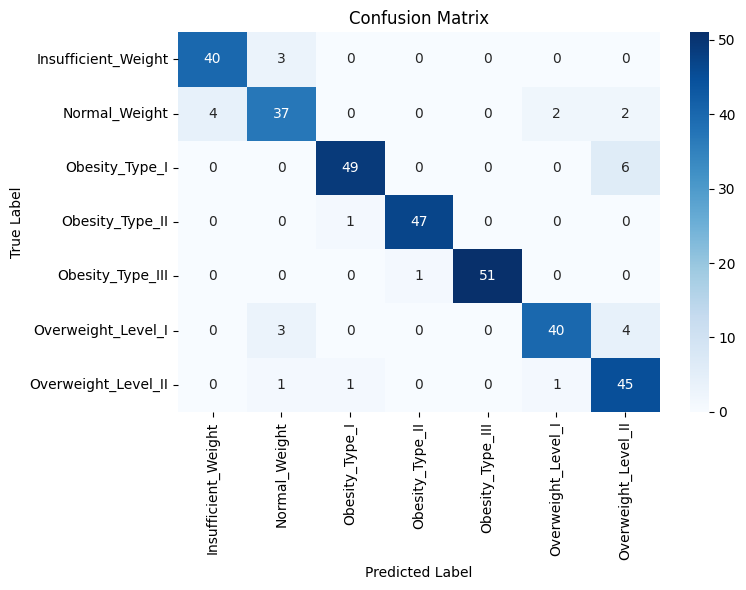

In [ ]:
best_model.eval()

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_final).float()
    outputs = best_model(X_test_tensor)
    preds = outputs.argmax(1).cpu().numpy()

print("\nTEST ACCURACY:", accuracy_score(y_test_enc, preds))
print("TEST F1:", f1_score(y_test_enc, preds, average="weighted"))

print("\nClassification Report:")
print(classification_report(
    y_test_enc,
    preds,
    target_names=label_encoder.classes_
))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

save_path = r"C:\Users\jiaro\DS4021-final-project\confusion_matrix.png" # saving the plot as a png!
plt.savefig(save_path, dpi=300)

plt.show()
